In [54]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Generating training and testing dataset

In [55]:

# Define the minimum and maximum length of sequences
min_len = 2
max_len = 9

# Define the size of the dataset
dataset_size = 5000

# Initialize the dataset arrays
X = []
y = []

# Generate random sequences and labels
for i in range(dataset_size):
    # Pick random sequence length from min_len to max_len
    seq_len = random.randint(min_len,max_len)
    # Define a seq with seq_len
    seq = torch.rand(seq_len,2)
    # Now in the second dimension 2 entries need to be 1 and rest 0
    # mark will be the array to do that, initialize it with all zeros
    mark = torch.zeros(seq_len)
    # pick 2 of the indexes which will have 1 at position
    mark_idx = random.sample(range(seq_len),2)
    mark[mark_idx] = 1
    # Updating the X value
    seq[:,1] = mark
    X.append(seq)
    #The y value will be sum of entries with 1
    y.append(torch.sum(seq[:, 0] * mark))

# Split the dataset into training and testing sets
train_size = int(dataset_size * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

### Helper Functions

In [56]:
# Activation Functions
def tanh(x):
    a = torch.exp(x)
    b = torch.exp(-x)
    return torch.div(a-b,a+b)

def sigmoid(x):
  return 1/(1+torch.exp(-x))

# Loss Functions
def mse_loss(output,target):
    return torch.sum(torch.square(output-target))

# Elmon RNN

In [57]:
class ElmonRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ElmonRNN, self).__init__()
        self.hidden_size = hidden_size
        self.Wxh = nn.Linear(input_size, hidden_size, bias=True)
        self.Whh = nn.Linear(hidden_size, hidden_size, bias=True)
        self.Why = nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, input):
        # Initially h_0 = 0
        h_t = torch.zeros(self.hidden_size)
        seq_len = input.size(0)
        for i in range(seq_len):
            h_t = tanh(self.Wxh(input[i])+self.Whh(h_t))
        output = self.Why(h_t)
        return output


hidden_size = 1
learning_rate = 0.001
n_epochs = 10

model = ElmonRNN(2, hidden_size, 1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# To plot learning curves we must have following arrays
training_losses=[]
testing_losses =[]

for epoch in range(n_epochs):

    # Putting model in training Mode
    model.train()
    train_epoch_loss = 0
    for index,input in enumerate(train_X):
        y_pred = model.forward(input)
        loss = mse_loss(y_pred, train_y[index])
        train_epoch_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_losses.append(train_epoch_loss/len(train_X))

    # Putting Model in Test mode
    model.eval()
    test_epoch_loss = 0
    for index,input in enumerate(test_X):
        y_pred = model.forward(input)
        loss = mse_loss(y_pred, test_y[index])
        test_epoch_loss+=loss.item()
    testing_losses.append(test_epoch_loss/len(test_X))

    # Printing Epoch number, Average training and testing loses after each epoch
    print("Epoch: {}/{}".format(epoch+1, n_epochs))
    print("Average training loss: {:.4f}".format(train_epoch_loss/len(train_X)))
    print("Average testing loss: {:.4f}".format(test_epoch_loss/len(test_X)))
elmon_loss = testing_losses[-1]

Epoch: 1/10
Average training loss: 0.1632
Average testing loss: 0.1455
Epoch: 2/10
Average training loss: 0.1399
Average testing loss: 0.1298
Epoch: 3/10
Average training loss: 0.1286
Average testing loss: 0.1214
Epoch: 4/10
Average training loss: 0.1191
Average testing loss: 0.1139
Epoch: 5/10
Average training loss: 0.1137
Average testing loss: 0.1107
Epoch: 6/10
Average training loss: 0.1111
Average testing loss: 0.1087
Epoch: 7/10
Average training loss: 0.1096
Average testing loss: 0.1077
Epoch: 8/10
Average training loss: 0.1089
Average testing loss: 0.1073
Epoch: 9/10
Average training loss: 0.1085
Average testing loss: 0.1071
Epoch: 10/10
Average training loss: 0.1083
Average testing loss: 0.1071


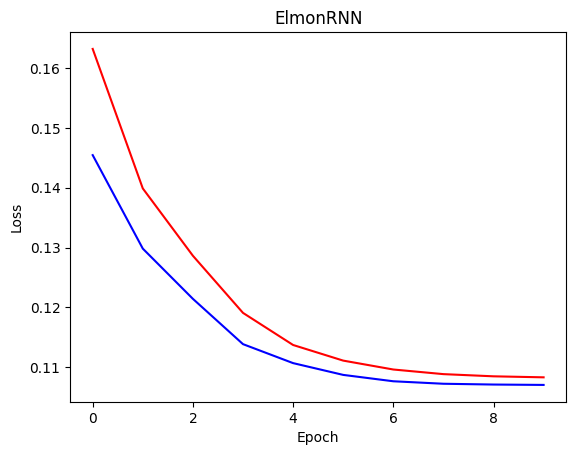

In [58]:
plt.plot(training_losses,label="Average training Loss",color="red")
plt.plot(testing_losses,label = "Average testing Loss",color = "blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ElmonRNN")
plt.show()

# LSTM

In [59]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.Wf = nn.Linear(input_size+hidden_size, hidden_size, bias=True)
        self.Wi = nn.Linear(input_size+hidden_size, hidden_size, bias=True)
        self.Wo = nn.Linear(input_size+hidden_size, hidden_size, bias=True)
        self.Wc = nn.Linear(input_size+hidden_size, hidden_size, bias=True)
        self.Why = nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, input):
        # Initially h_0 = 0 and C = 0

        h_t = torch.zeros(self.hidden_size)
        c_t = torch.zeros(self.hidden_size)  # Cell State
        seq_len = input.size(0)
        for i in range(seq_len):
            f_t = sigmoid(self.Wf(torch.cat((input[i], h_t))))  # Forget gate
            i_t = sigmoid(self.Wi(torch.cat((input[i], h_t))))  # Input Gate
            c_modifier = tanh(self.Wc(torch.cat((input[i], h_t)))) # New Candidate value to update cell state
            c_t = f_t*c_t+i_t*c_modifier # Cell state Updated

            o_t = sigmoid(self.Wo(torch.cat((input[i], h_t))))
            h_t = torch.mul(o_t,tanh(c_t))
        output = self.Why(h_t)
        return output


hidden_size = 10
learning_rate = 0.001
n_epochs = 5

model = LSTM(2, hidden_size, 1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# To plot learning curves we must have following arrays
training_losses = []
testing_losses = []

for epoch in range(n_epochs):

    # Putting model in training Mode
    model.train()
    train_epoch_loss = 0
    for index, input in enumerate(train_X):
        y_pred = model(input)
        optimizer.zero_grad()
        loss = mse_loss(y_pred, train_y[index])
        train_epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    training_losses.append(train_epoch_loss/len(train_X))
    
    # Putting Model in Test mode
    model.eval()
    test_epoch_loss = 0
    for index, input in enumerate(test_X):
        y_pred = model(input)
        loss = mse_loss(y_pred, test_y[index])
        test_epoch_loss += loss.item()
    testing_losses.append(test_epoch_loss/len(test_X))
    
    # Printing Epoch number, Average training and testing loses after each epoch
    print("Epoch: {}/{}".format(epoch+1, n_epochs))
    print("Average training loss: {:.4f}".format(train_epoch_loss/len(train_X)))
    print("Average testing loss: {:.4f}".format(test_epoch_loss/len(test_X)))
lstm_loss = testing_losses[-1]

Epoch: 1/5
Average training loss: 0.1093
Average testing loss: 0.0399
Epoch: 2/5
Average training loss: 0.0158
Average testing loss: 0.0040
Epoch: 3/5
Average training loss: 0.0023
Average testing loss: 0.0009
Epoch: 4/5
Average training loss: 0.0010
Average testing loss: 0.0005
Epoch: 5/5
Average training loss: 0.0007
Average testing loss: 0.0004


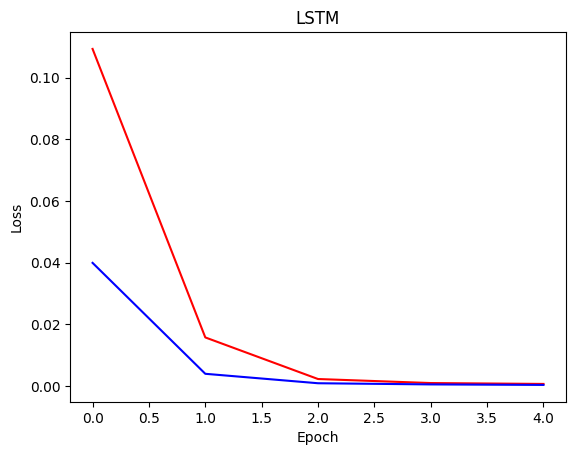

In [60]:
plt.plot(training_losses,label="Average training Loss",color="red")
plt.plot(testing_losses,label = "Average testing Loss",color = "blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM")
plt.show()

# GRU

In [69]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.Wz = nn.Linear(input_size+hidden_size, hidden_size, bias=True)
        self.Wr = nn.Linear(input_size+hidden_size, hidden_size, bias=True)
        self.Wh = nn.Linear(input_size+hidden_size, hidden_size, bias=True)
        self.Why = nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, input):
        # Initially h_0 = 0 and C = 0

        h_t = torch.zeros(self.hidden_size)
        seq_len = input.size(0)
        for i in range(seq_len):
            z = sigmoid(self.Wz(torch.cat((input[i], h_t))))
            r = sigmoid(self.Wr(torch.cat((input[i], h_t))))
            h_t = tanh(self.Wh(torch.cat((input[i], r*h_t))))
            h_t = (1-z)*h_t+z*h_t
        output = self.Why(h_t)
        return output


hidden_size = 10
learning_rate = 0.001
n_epochs = 5

model = GRU(2, hidden_size, 1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# To plot learning curves we must have following arrays
training_losses = []
testing_losses = []

for epoch in range(n_epochs):

    # Putting model in training Mode
    model.train()
    train_epoch_loss = 0
    for index, input in enumerate(train_X):
        y_pred = model.forward(input)
        loss = mse_loss(y_pred, train_y[index])
        train_epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_losses.append(train_epoch_loss/len(train_X))

    # Putting Model in Test mode
    model.eval()
    test_epoch_loss = 0
    for index, input in enumerate(test_X):
        y_pred = model.forward(input)
        loss = mse_loss(y_pred, test_y[index])
        test_epoch_loss += loss.item()
    testing_losses.append(test_epoch_loss/len(test_X))

    # Printing Epoch number, Average training and testing loses after each epoch
    print("Epoch: {}/{}".format(epoch+1, n_epochs))
    print("Average training loss: {:.4f}".format(train_epoch_loss/len(train_X)))
    print("Average testing loss: {:.4f}".format(test_epoch_loss/len(test_X)))
gru_loss = testing_losses[-1]

Epoch: 1/5
Average training loss: 0.1455
Average testing loss: 0.1006
Epoch: 2/5
Average training loss: 0.0795
Average testing loss: 0.0369
Epoch: 3/5
Average training loss: 0.0216
Average testing loss: 0.0136
Epoch: 4/5
Average training loss: 0.0114
Average testing loss: 0.0082
Epoch: 5/5
Average training loss: 0.0071
Average testing loss: 0.0047


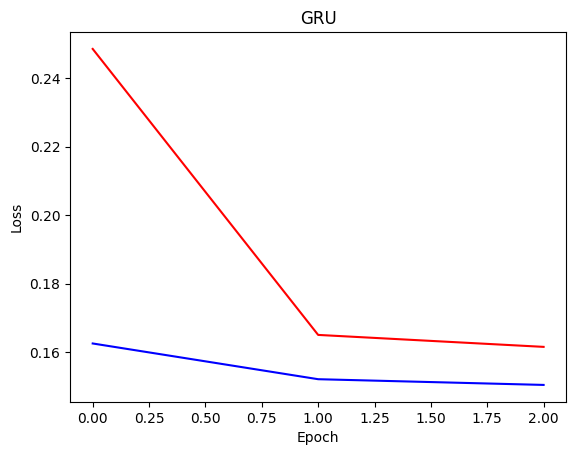

In [62]:
plt.plot(training_losses,label="Average training Loss",color="red")
plt.plot(testing_losses,label = "Average testing Loss",color = "blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GRU")
plt.show()

# BaseLine Comparison

In [63]:
# To compute baseline loss
size = len(test_X)
y_predicted = torch.ones(size)
baseline_loss = (mse_loss(y_predicted,torch.tensor(test_y)).item())/size

### Plotting Line chart for losses

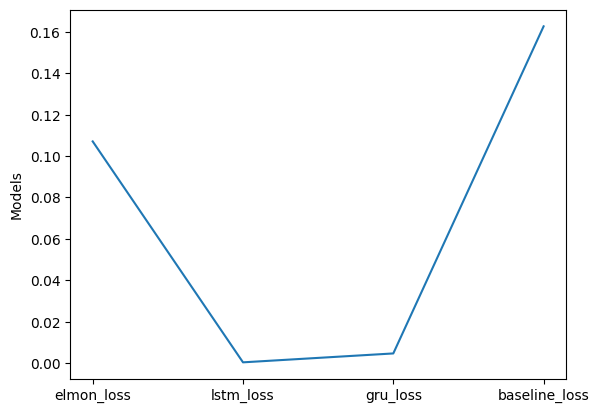

In [70]:
losses = [elmon_loss,lstm_loss,gru_loss,baseline_loss]

# create a line chart
plt.plot(range(4), losses)

# set the x-axis labels
plt.xticks(range(4), ['elmon_loss','lstm_loss','gru_loss','baseline_loss'])

# set the y-axis label
plt.ylabel('Models')

# show the plot
plt.show()